🚀 Starting Data Ingestion...
✅ Datasets loaded successfully.
⚙️ Aligning Timestamps...
✅ Merged Data: 211224 trades ready for analysis.
📊 Generating Insights...


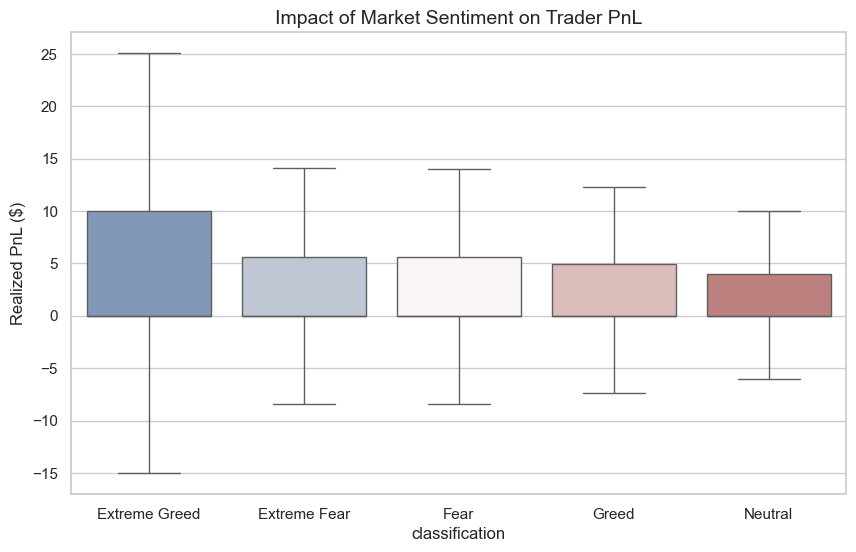

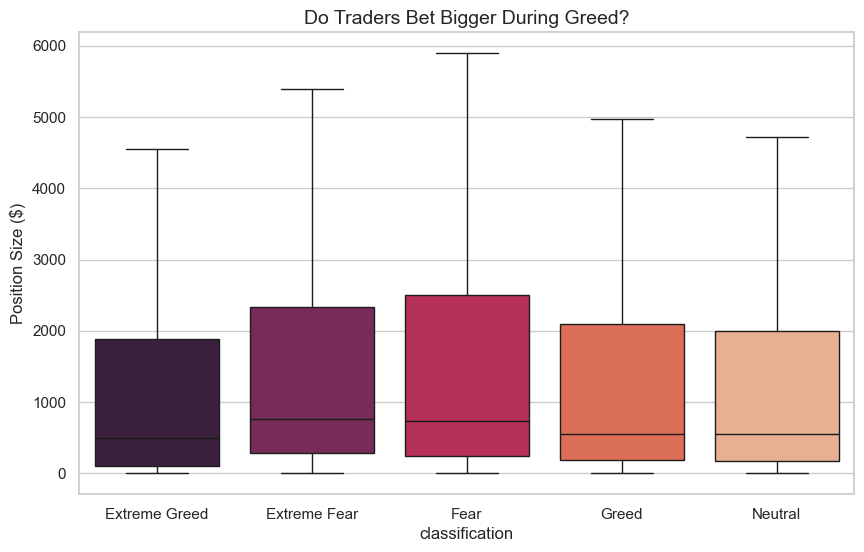

🧠 Running Unsupervised Learning (Clustering)...


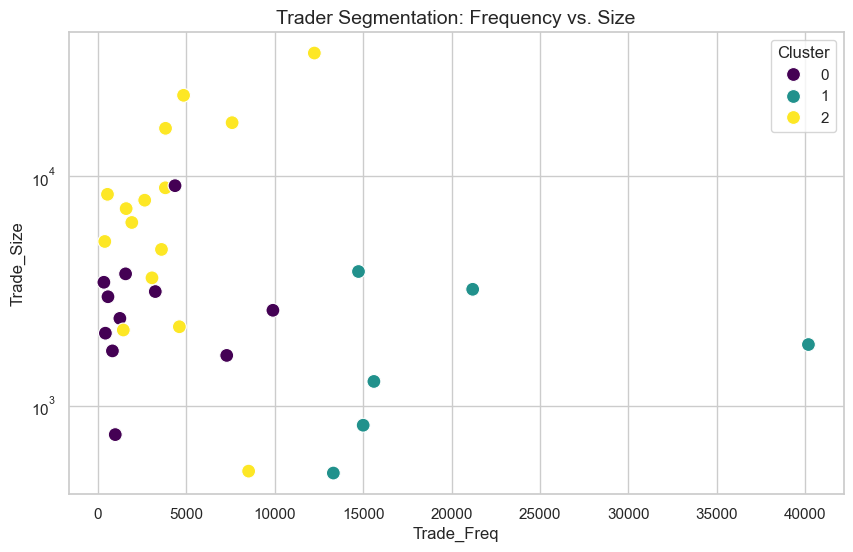

✅ Analysis Complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- 1. DATA INGESTION ---
print("🚀 Starting Data Ingestion...")

# Load Data (Adjusting paths to step out of 'notebooks' folder into 'data')
try:
    df_sentiment = pd.read_csv('/Users/anubhavmaandey/Desktop/Primetrade_Assignment/data/Sentiment_data.csv')
    df_trades = pd.read_csv('/Users/anubhavmaandey/Desktop/Primetrade_Assignment/data/trade_date.csv')
    print("✅ Datasets loaded successfully.")
except FileNotFoundError:
    print("❌ Error: Files not found. Ensure they are in the 'data' folder.")

# --- 2. DATA CLEANING & ALIGNMENT ---
print("⚙️ Aligning Timestamps...")

# Fix Sentiment Dates
df_sentiment['Date'] = pd.to_datetime(df_sentiment['date'])

# Fix Trade Dates (Format: DD-MM-YYYY HH:MM)
# We use 'dayfirst=True' to correctly interpret 02-12 as Dec 2nd
df_trades['time'] = pd.to_datetime(df_trades['Timestamp IST'], dayfirst=True)
df_trades['Date'] = df_trades['time'].dt.normalize()

# Merge: Left Join on Date to attach Sentiment to every Trade
df_merged = pd.merge(df_trades, df_sentiment[['Date', 'classification', 'value']], on='Date', how='left')
df_merged['classification'] = df_merged['classification'].fillna('Neutral')

print(f"✅ Merged Data: {len(df_merged)} trades ready for analysis.")

# --- 3. FEATURE ENGINEERING ---
# Creating 'Alpha' metrics
df_merged['win'] = np.where(df_merged['Closed PnL'] > 0, 1, 0)
# using 'Size USD' as proxy for Conviction/Risk
df_merged['Trade_Size'] = df_merged['Size USD']

# --- 4. ANALYSIS VISUALIZATIONS ---
print("📊 Generating Insights...")

# Plot A: PnL Distribution by Sentiment
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='Closed PnL', data=df_merged, showfliers=False, palette="vlag")
plt.title('Impact of Market Sentiment on Trader PnL', fontsize=14)
plt.ylabel('Realized PnL ($)')
plt.savefig('pnl_analysis.png') # Saves image for your report
plt.show()

# Plot B: Risk Appetite (Size) by Sentiment
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='Trade_Size', data=df_merged, showfliers=False, palette="rocket")
plt.title('Do Traders Bet Bigger During Greed?', fontsize=14)
plt.ylabel('Position Size ($)')
plt.show()

# --- 5. CLUSTERING (The Bonus) ---
print("🧠 Running Unsupervised Learning (Clustering)...")

# Aggregate per User
user_profiles = df_merged.groupby('Account').agg({
    'Closed PnL': 'sum',
    'Trade_Size': 'mean',
    'win': 'mean',
    'Date': 'count'
}).rename(columns={'Date': 'Trade_Freq'})

# Filter for relevant traders (> 2 trades)
active_users = user_profiles[user_profiles['Trade_Freq'] > 2].copy()

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(active_users[['Trade_Size', 'win', 'Trade_Freq']])

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
active_users['Cluster'] = kmeans.fit_predict(X)

# Visualizing Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=active_users, x='Trade_Freq', y='Trade_Size', hue='Cluster', palette='viridis', s=100)
plt.title('Trader Segmentation: Frequency vs. Size', fontsize=14)
plt.yscale('log') # Log scale for better view of whales
plt.show()

print("✅ Analysis Complete.")